In [1]:
# Import necessary library
import json
import requests
import pandas as pd
import numpy as np
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
# import k-means from clustering stage
from sklearn.cluster import KMeans
#import packages for visulization
import seaborn as sns
import matplotlib.pyplot as plt

# Data from web scrapping

In [2]:
from pandas.io.html import read_html

#data from wikipedia.org
url='https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'
#Data scarpping
wikitable = read_html(url,  attrs={"class":"wikitable"},header =0)

#Dataframe management
wiki_df = pd.DataFrame(wikitable[0])
wiki_df= wiki_df.rename(columns={'District(Khet)':'District'})
wiki_df= wiki_df.rename(columns={'No. ofSubdistricts(Khwaeng)':'No_of_Subdistricts'})
wiki_df= wiki_df.rename(columns={'Thai':'DistrictThai'})
wiki_df['Latitude'].fillna(0, inplace=True)
wiki_df['Longitude'].fillna(0, inplace=True)
wiki_df.head(20)

,District,MapNr,Post-code,DistrictThai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500
5,Bang Khun Thian,21,10150,บางขุนเทียน,165491,2,13.660833,100.435833
6,Bang Na,47,10260,บางนา,95912,2,13.680081,100.591800
7,Bang Phlat,25,10700,บางพลัด,99273,4,13.793889,100.505000
8,Bang Rak,4,10500,บางรัก,45875,5,13.730833,100.524167
9,Bang Sue,29,10800,บางซื่อ,132234,2,13.809722,100.537222


In [3]:
wiki_df[wiki_df.Latitude ==0 | wiki_df.Latitude.isna()]

,District,MapNr,Post-code,DistrictThai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude


In [4]:
wiki_df.shape

(50, 8)

In [5]:
wiki_df = wiki_df.rename(columns = {'Popu-lation':'Population','No. ofSubdis-trictsKhwaeng':'No.subdistrict', 'Post-code':'Postal Code'})

In [6]:
display(wiki_df.columns)
print('Bangkok the capital city of Thailand has total population', wiki_df.Population.sum(), 'in 2021')

Index(['District', 'MapNr', 'Postal Code', 'DistrictThai', 'Population',
       'No.subdistrict', 'Latitude', 'Longitude'],
      dtype='object')

Bangkok the capital city of Thailand has total population 5671070 in 2021


## Data fetching from Foursquare

In [7]:
CLIENT_ID='CKHL1D1D1OFKBSLAUMC22VXCKQRQGH2GPHJAWXDJQS5DZLR5'
CLIENT_SECRET='4D2TPJQHRHCFJAZ5Q1X0S4WJR3BISU0NROOZOPGJGT11WRSN'
VERSION = '20200605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CKHL1D1D1OFKBSLAUMC22VXCKQRQGH2GPHJAWXDJQS5DZLR5
CLIENT_SECRET:4D2TPJQHRHCFJAZ5Q1X0S4WJR3BISU0NROOZOPGJGT11WRSN


In [8]:
radius = 5000
LIMIT = 100
df_1 = wiki_df.copy()
venues = []

for lat, long, dist, pop, code in zip(df_1['Latitude'], df_1['Longitude'], df_1['District'], df_1['Postal Code'], df_1['Population']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        venues.append((
            dist, 
            code,
            pop,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['id'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [9]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['District', 'Population', 'Postal Code', 'Latitude', 'Longitude', 'VenueName','VenueId', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
venues_df

,District,Population,Postal Code,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueCategory
0,Bang Bon,105161,10150,13.659200,100.399100,ข้าวต้มม้วน,4ec7d62f0e6158bafef41324,13.666550,100.412108,Asian Restaurant
1,Bang Bon,105161,10150,13.659200,100.399100,ขาหมูบางหว้า,4e880a81f790e992e01d7284,13.657136,100.395230,Thai Restaurant
2,Bang Bon,105161,10150,13.659200,100.399100,Burger King (เบอร์เกอร์คิง),5884172803e29a6e0f77197e,13.670830,100.405089,Fast Food Restaurant
3,Bang Bon,105161,10150,13.659200,100.399100,Mitta Cafe (มิตตะ คาเฟ่),54b4b9f9498eb25857e0ef66,13.637555,100.404097,Coffee Shop
4,Bang Bon,105161,10150,13.659200,100.399100,7-Eleven (เซเว่น อีเลฟเว่น),4d907cedd00a6ea85cb2e44f,13.656440,100.394178,Convenience Store
...,...,...,...,...,...,...,...,...,...,...
4704,Yan Nawa,81521,10120,13.696944,100.543056,ตลาดนัดสีลมซอย10 (หลังตึกITF),4ca029a82fb1a1432750fa40,13.727724,100.528384,Food Court
4705,Yan Nawa,81521,10120,13.696944,100.543056,Baan sabai spa,55436c58498ea66a93ed3dc6,13.724701,100.569836,Spa
4706,Yan Nawa,81521,10120,13.696944,100.543056,Indicus Bistro,54df4260498e8f442feaae1c,13.734441,100.539380,Wine Bar
4707,Yan Nawa,81521,10120,13.696944,100.543056,เล่าสี่ เกาเหลาเลือดหมู,4d0c482695c1a1cd5283fbfe,13.711892,100.512245,Asian Restaurant


In [10]:
venues_df.to_csv("venues_df.csv", sep='\t', encoding='utf-8')

## Data segmentation

In [11]:
venues_df.VenueCategory.value_counts()

Convenience Store     558
Coffee Shop           413
Thai Restaurant       369
Noodle House          352
Hotel                 193
                     ... 
Forest                  1
Car Wash                1
Other Repair Shop       1
Frozen Yogurt Shop      1
Concert Hall            1
Name: VenueCategory, Length: 196, dtype: int64

In [12]:
coffee_df = venues_df[venues_df.VenueCategory == 'Coffee Shop']
print('Bangkok has {} coffee shops'. format(len(coffee_df)))
display(coffee_df.head())


Bangkok has 413 coffee shops


,District,Population,Postal Code,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueCategory
3,Bang Bon,105161,10150,13.6592,100.3991,Mitta Cafe (มิตตะ คาเฟ่),54b4b9f9498eb25857e0ef66,13.637555,100.404097,Coffee Shop
11,Bang Bon,105161,10150,13.6592,100.3991,Starbucks (สตาร์บัคส์),57668344498ea21c0ae58946,13.694460,100.408111,Coffee Shop
19,Bang Bon,105161,10150,13.6592,100.3991,Koff & Bun By ไต้แป๊ะ,57cba5a9498ea02d4ebd80b2,13.683944,100.413320,Coffee Shop
32,Bang Bon,105161,10150,13.6592,100.3991,Starbucks (สตาร์บัคส์),59bcea2135f9832f5b3a7420,13.664258,100.439082,Coffee Shop
34,Bang Bon,105161,10150,13.6592,100.3991,Starbucks Reserve (สตาร์บัคส์ รีเสิร์ฟ),4bc0040d461576b003b07932,13.663825,100.437668,Coffee Shop


In [13]:
geolocator = Nominatim(user_agent="to_explorer")
bangkok = geolocator.geocode('Bangkok')

map_venues = folium.Map(location=[bangkok.latitude, bangkok.longitude], zoom_start=10)
 
for lat, long, name, cat in zip(coffee_df['VenueLatitude'], coffee_df['VenueLongitude'], coffee_df['VenueName'], \
                                      coffee_df['VenueCategory']):
    label = '{}, {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        color='#E42222',
        fill=True,
        fill_color='#CB9D5B',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)  
    
map_venues

In [14]:
Coffee_shop = coffee_df['District'].value_counts().nlargest(5)
Coffee_shop

Bang Kapi        16
Bang Khae        16
Chatuchak        15
Phasi Charoen    14
Suan Luang       13
Name: District, dtype: int64

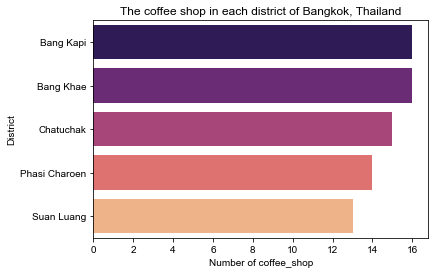

In [15]:
# create dataframe for plot
coffee_top = pd.DataFrame(Coffee_shop).reset_index()
coffee_top.columns = ['District','Number of coffee_shop']
coffee_top 
#create plot
sns.barplot(x = 'Number of coffee_shop', y = 'District', data = coffee_top[:10], palette = 'magma')
sns.set_style('darkgrid')
plt.title('The coffee shop in each district of Bangkok, Thailand')
plt.xticks(rotation=0)
plt.show()

## Onehot encoding method

In [16]:
# one hot encoding
df_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['District'] = venues_df['District'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

print(df_onehot.shape)
df_onehot.head()

(4709, 197)


,District,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,Bang Bon,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_grouped = df_onehot.groupby(["District"]).mean().reset_index()

print(df_grouped.shape)
df_grouped.drop('Convenience Store', axis=1, inplace=True)
df_grouped.head()

(50, 197)


,District,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,Bang Bon,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.04,...,0.0,0.01,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0
1,Bang Kapi,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,Bang Khae,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.03,...,0.0,0.00,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0
3,Bang Khen,0.0,0.0,0.01,0.00,0.0,0.0,0.01,0.0,0.01,...,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
4,Bang Kho Laem,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.08,...,0.0,0.01,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0


In [18]:
len(df_grouped[df_grouped["Coffee Shop"] > 0])

50

In [19]:
#where is the large number of coffee shop?
show = df_grouped.groupby(['District'])['Coffee Shop'].sum().nlargest(5)
show

District
Bang Kapi        0.16
Bang Khae        0.16
Chatuchak        0.15
Phasi Charoen    0.14
Bang Na          0.13
Name: Coffee Shop, dtype: float64

In [20]:
num_top_venues = 5

for hood in df_grouped['District']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bang Bon----
              venue  freq
0       Coffee Shop  0.12
1   Thai Restaurant  0.12
2      Noodle House  0.06
3            Market  0.04
4  Asian Restaurant  0.04


----Bang Kapi----
             venue  freq
0      Coffee Shop  0.16
1  Thai Restaurant  0.13
2     Noodle House  0.12
3     Dessert Shop  0.05
4             Café  0.04


----Bang Khae----
              venue  freq
0       Coffee Shop  0.16
1   Thai Restaurant  0.07
2      Noodle House  0.07
3         BBQ Joint  0.04
4  Asian Restaurant  0.03


----Bang Khen----
                venue  freq
0         Coffee Shop  0.11
1        Noodle House  0.08
2     Thai Restaurant  0.07
3  Som Tum Restaurant  0.05
4         Supermarket  0.05


----Bang Kho Laem----
              venue  freq
0  Asian Restaurant  0.08
1       Coffee Shop  0.08
2             Hotel  0.07
3   Thai Restaurant  0.06
4               Spa  0.05


----Bang Khun Thian----
              venue  freq
0       Coffee Shop  0.11
1   Thai Restaurant  0.08
2      No

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = df_grouped['District']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bang Bon,Thai Restaurant,Coffee Shop,Noodle House
1,Bang Kapi,Coffee Shop,Thai Restaurant,Noodle House
2,Bang Khae,Coffee Shop,Noodle House,Thai Restaurant
3,Bang Khen,Coffee Shop,Noodle House,Thai Restaurant
4,Bang Kho Laem,Asian Restaurant,Coffee Shop,Hotel


In [22]:
#How many venues each district has
df_1 = df_grouped.melt(id_vars='District', var_name='Venues', value_name='Onehot')
display(df_1)
df_2 = df_1.groupby('Venues')['Onehot'].agg('sum')
names = df_2.sort_values(ascending=False).nlargest(15)
names

,District,Venues,Onehot
0,Bang Bon,Accessories Store,0.0
1,Bang Kapi,Accessories Store,0.0
2,Bang Khae,Accessories Store,0.0
3,Bang Khen,Accessories Store,0.0
4,Bang Kho Laem,Accessories Store,0.0
...,...,...,...
9745,Thon Buri,Zoo,0.0
9746,Thung Khru,Zoo,0.0
9747,Wang Thonglang,Zoo,0.0
9748,Watthana,Zoo,0.0


Venues
Coffee Shop            4.322418
Thai Restaurant        3.922610
Noodle House           3.721609
Hotel                  1.961707
Café                   1.698454
Dessert Shop           1.224408
Asian Restaurant       1.147179
Som Tum Restaurant     1.101690
Japanese Restaurant    0.965873
Seafood Restaurant     0.893583
Spa                    0.852727
Supermarket            0.788768
Hotpot Restaurant      0.769964
Park                   0.767695
Chinese Restaurant     0.733612
Name: Onehot, dtype: float64

## Clustering 

In [23]:
# set number of clusters
kclusters = 5

# run k-means clustering
df_clustering = df_grouped.drop('District', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 0, 3, 3, 1, 2, 3])

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_, True) 
neighborhoods_venues_sorted.head()

,Cluster,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,3,Bang Bon,Thai Restaurant,Coffee Shop,Noodle House
1,3,Bang Kapi,Coffee Shop,Thai Restaurant,Noodle House
2,3,Bang Khae,Coffee Shop,Noodle House,Thai Restaurant
3,3,Bang Khen,Coffee Shop,Noodle House,Thai Restaurant
4,0,Bang Kho Laem,Asian Restaurant,Coffee Shop,Hotel


In [25]:
df_clustered = neighborhoods_venues_sorted.copy()
df_clustered = df_clustered.join(wiki_df.set_index("District"), on="District")
df_clustered = df_clustered.iloc[:, np.r_[0:5, 8:12]]
print(df_clustered.shape)
df_clustered

(50, 9)


,Cluster,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,No.subdistrict,Latitude,Longitude
0,3,Bang Bon,Thai Restaurant,Coffee Shop,Noodle House,105161,4,13.659200,100.399100
1,3,Bang Kapi,Coffee Shop,Thai Restaurant,Noodle House,148465,2,13.765833,100.647778
2,3,Bang Khae,Coffee Shop,Noodle House,Thai Restaurant,191781,4,13.696111,100.409444
3,3,Bang Khen,Coffee Shop,Noodle House,Thai Restaurant,189539,2,13.873889,100.596389
4,0,Bang Kho Laem,Asian Restaurant,Coffee Shop,Hotel,94956,3,13.693333,100.502500
5,3,Bang Khun Thian,Coffee Shop,Thai Restaurant,Noodle House,165491,2,13.660833,100.435833
6,3,Bang Na,Coffee Shop,Thai Restaurant,Café,95912,2,13.680081,100.591800
7,1,Bang Phlat,Thai Restaurant,Noodle House,Café,99273,4,13.793889,100.505000
8,2,Bang Rak,Hotel,Spa,Thai Restaurant,45875,5,13.730833,100.524167
9,3,Bang Sue,Coffee Shop,Thai Restaurant,Noodle House,132234,2,13.809722,100.537222


## Data visualization

In [26]:
geolocator = Nominatim(user_agent="to_explorer")
bangkok = geolocator.geocode('Bangkok')

map_clusters = folium.Map(location=[bangkok.latitude, bangkok.longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['District'],\
                                  df_clustered['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
df_clustered.loc[df_clustered['Cluster'] == 0]

,Cluster,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,No.subdistrict,Latitude,Longitude
4,0,Bang Kho Laem,Asian Restaurant,Coffee Shop,Hotel,94956,3,13.693333,100.502500
11,0,Bangkok Yai,Coffee Shop,Asian Restaurant,Hotel,72321,2,13.722778,100.476389
14,0,Chom Thong,Noodle House,Coffee Shop,Asian Restaurant,158005,4,13.677222,100.484722
32,0,Phra Khanong,Coffee Shop,Café,Spa,93482,2,13.702222,100.601667
36,0,Rat Burana,Thai Restaurant,Asian Restaurant,Hotel,86695,2,13.682222,100.505556
45,0,Thon Buri,Coffee Shop,Hotel,Asian Restaurant,119708,7,13.725000,100.485833
49,0,Yan Nawa,Thai Restaurant,Hotel,Spa,81521,2,13.696944,100.543056


In [28]:
df_clustered.loc[df_clustered['Cluster'] == 1]

,Cluster,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,No.subdistrict,Latitude,Longitude
7,1,Bang Phlat,Thai Restaurant,Noodle House,Café,99273,4,13.793889,100.505000
10,1,Bangkok Noi,Noodle House,Thai Restaurant,Coffee Shop,117793,5,13.770867,100.467933
17,1,Dusit,Noodle House,Thai Restaurant,Hotel,107655,5,13.776944,100.520556
24,1,Lat Krabang,Thai Restaurant,Noodle House,Coffee Shop,163175,6,13.722317,100.759669
33,1,Phra Nakhon,Thai Restaurant,Noodle House,Dessert Shop,57876,12,13.764444,100.499167
44,1,Thawi Watthana,Thai Restaurant,Noodle House,Café,76351,2,13.787800,100.363800


In [29]:
df_clustered.loc[df_clustered['Cluster'] == 2]

,Cluster,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,No.subdistrict,Latitude,Longitude
8,2,Bang Rak,Hotel,Spa,Thai Restaurant,45875,5,13.730833,100.524167
15,2,Din Daeng,Hotel,Hostel,Noodle House,130220,2,13.769722,100.552778
21,2,Khlong San,Hotel,Thai Restaurant,Noodle House,76446,4,13.730278,100.509722
22,2,Khlong Toei,Spa,Japanese Restaurant,Café,109041,3,13.708056,100.583889
29,2,Pathum Wan,Hotel,Noodle House,Thai Restaurant,53263,4,13.744942,100.522200
31,2,Phaya Thai,Noodle House,Coffee Shop,Hotel,72952,2,13.780000,100.542778
34,2,Pom Prap Sattru Phai,Noodle House,Hotel,Thai Restaurant,51006,5,13.758056,100.513056
37,2,Ratchathewi,Hotel,Noodle House,Thai Restaurant,73035,4,13.758889,100.534444
39,2,Samphanthawong,Hotel,Thai Restaurant,Noodle House,27452,3,13.731389,100.514167
41,2,Sathon,Hotel,Coffee Shop,Thai Restaurant,84916,3,13.708056,100.526389


In [30]:
df_clustered.loc[df_clustered['Cluster'] == 3]

,Cluster,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,No.subdistrict,Latitude,Longitude
0,3,Bang Bon,Thai Restaurant,Coffee Shop,Noodle House,105161,4,13.659200,100.399100
1,3,Bang Kapi,Coffee Shop,Thai Restaurant,Noodle House,148465,2,13.765833,100.647778
2,3,Bang Khae,Coffee Shop,Noodle House,Thai Restaurant,191781,4,13.696111,100.409444
3,3,Bang Khen,Coffee Shop,Noodle House,Thai Restaurant,189539,2,13.873889,100.596389
5,3,Bang Khun Thian,Coffee Shop,Thai Restaurant,Noodle House,165491,2,13.660833,100.435833
6,3,Bang Na,Coffee Shop,Thai Restaurant,Café,95912,2,13.680081,100.591800
9,3,Bang Sue,Coffee Shop,Thai Restaurant,Noodle House,132234,2,13.809722,100.537222
12,3,Bueng Kum,Coffee Shop,Thai Restaurant,Noodle House,145830,3,13.785278,100.669167
13,3,Chatuchak,Coffee Shop,Café,Thai Restaurant,160906,5,13.828611,100.559722
16,3,Don Mueang,Coffee Shop,Som Tum Restaurant,Thai Restaurant,166261,3,13.913611,100.589722


In [31]:
df_clustered.loc[df_clustered['Cluster'] == 4]

,Cluster,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,No.subdistrict,Latitude,Longitude
20,4,Khlong Sam Wa,Coffee Shop,Thai Restaurant,Golf Course,169489,5,13.859722,100.704167
27,4,Nong Chok,Flea Market,Café,Noodle House,157138,8,13.855556,100.862500
28,4,Nong Khaem,Flea Market,Thai Restaurant,Market,150218,2,13.704722,100.348889


## Conclusion
From the analysis, The most proper location is on cluster no.3 which most common venue of districts are Coffee Shop and the population on average is more than 100,000 people. Looking at location, the cluster no.3 places around the inner zone of Bangkok and outer zone that is the resident zone and 1 districts has the Don-Meaung international airport which is the 2nd largest international airport in Thailand. But keep in mind, you will have a lot of compettiors some of them are the international brands. In conclusion, you need to choose your locations based on considers 3 factors 1) The locations based on nearby venues 2) The number of populations as the proxy of your customers and 3) The number of compettitors